#Implementation of Point 3
------
##Definition of Point 3
Finally, take the following dataset (https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip), train on this dataset and provide test accuracy on the MNIST test set, using the same test split from part 2. Train using scratch random initialization and using the pretrained network part 1. Do the same analysis as 2 and report what happens this time. Try and do qualitative analysis of what's different in this dataset. Please save your model checkpoints.

###Solution
This notebook contains the model being **trained from scratch**. The model is trained on a revised dataset and is tested on MNIST.
###Model Architecture

<font size=3px>
1. Conv(1, 32) -> ReLU -> Dropout -> Maxpool</br>
2. Conv(32, 64) -> ReLU -> Dropout -> Maxpool</br>
3. Conv(64, 128) -> ReLU -> Dropout -> Maxpool</br>
4. Conv(128, 256) -> ReLU -> Dropout -> Maxpool</br>
5. Conv(256, 512) -> ReLU -> Dropout -> Maxpool</br>
6. Transformer Encoder Layer</br>
7. Transformer Encoder Layer</br>
8. Transformer Encoder Layer</br>
9. Fully Connected Layer (512, 10)</br>
</font>

<font color='blue'>Optimizer</font>: Adam (lr: 0.0001)</br>
<font color='blue'>Loss</font>: CrossEntropyLoss</br>


**Conclusions**</br>
At epoch 20:</br>
Training Accuracy: 99.39% 	
Validation Accuracy: 99.23%<br>
Test Accuracy: 99%


<font color='grey'>*The following code is implemented in PyTorch.*</font>


#Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pycm

In [ ]:
# Point 3's data is accessed via the zip file stored in the drive
# This zip file is transferred to the disk of the google colab, 
# because accessing it from the disk directly is faster than
# accessing the images from the drive

#Link to the zip file: https://drive.google.com/file/d/1bWjl661Kk3xa8MmdXKHAwsr48080LaQG/view?usp=sharing
!cp -r "/content/drive/MyDrive/MIDAS/Point3/mnistTask.zip" "/content/mnistTask.zip"
!unzip mnistTask.zip

In [ ]:
import numpy as np
import torch
import csv
from torch import nn
import pandas as pd
import cv2 as cv
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, ZeroPad2d
from torchvision import transforms, datasets
import shutil
from sklearn.metrics import auc, confusion_matrix, classification_report
import seaborn as sns
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import random
#from pycm import *

#Data Preparation

In [ ]:
def _preprocess(image):
    # Preprocssing step
    img_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((200, 200)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5,))
    ])
    return img_transform(image)

def _preprocess_aug(image):
  transform_aug = transforms.Compose([
     transforms.ToPILImage(),                                     
     transforms.Resize((200, 200)),                                                        
     transforms.RandomRotation(20),
     #transforms.RandomAffine(0),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5,))
    ])

  return transform_aug(image)

In [ ]:
class Images_train(Dataset):
  def __init__(self, df):
        self.data = df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #print(index)
    image1 = cv.imread(self.data.iloc[index, 0], cv.IMREAD_GRAYSCALE)
    temp=random.randint(0,1)
    if temp == 1:
      image1 = _preprocess_aug(image1)
    else:
      image1 = _preprocess(image1)

    label = self.data.iloc[index, 1]

    return image1, torch.from_numpy(np.array([label], dtype=np.float32))

In [ ]:
class Images_test(Dataset):
  def __init__(self, df):
        self.data = df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #print(index)
    image1 = cv.imread(self.data.iloc[index, 0], cv.IMREAD_GRAYSCALE)
    image1 = _preprocess(image1)

    label = self.data.iloc[index, 1]

    return image1, torch.from_numpy(np.array([label], dtype=np.float32))

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MIDAS/Point3/dataset_p3.csv")
df = df.sample(frac = 1)
df.head()

,FilePath,Label
53645,/content/mnistTask/2/image_056445.jpg,4
58450,/content/mnistTask/5/image_056616.jpg,3
55685,/content/mnistTask/3/image_055346.jpg,7
990,/content/mnistTask/8/image_034122.jpg,5
22330,/content/mnistTask/7/image_051109.jpg,6


In [ ]:
df.shape

(60000, 2)

In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.25)
"""df_train = pd.read_csv("/content/drive/MyDrive/MIDAS/Point3/train.csv")
df_train = df_train.sample(frac = 1)

df_valid = pd.read_csv("/content/drive/MyDrive/MIDAS/Point3/valid.csv")
df_valid = df_valid.sample(frac = 1)"""

train_dataset = Images_train(df_train)
valid_dataset = Images_test(df_valid)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

train_iter = iter(train_loader)
images1, labels = train_iter.next()
print('images shape on batch size = {}'.format(images1.size()))
print('labels shape on batch size = {}'.format(labels.size()))

val_iter = iter(val_loader)
images1, labels = val_iter.next()
print('images shape on batch size = {}'.format(images1.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 1, 200, 200])
labels shape on batch size = torch.Size([8, 1])
images shape on batch size = torch.Size([1, 1, 200, 200])
labels shape on batch size = torch.Size([1, 1])


###Visualing the data

Since this dataset is creating using the predictions from another model, this step is necessary.
Here is where the dataset is created: [Point2_Train_Scratch.ipynb](https://colab.research.google.com/drive/1W_n2OE5CFStZ0_nExiW_CekZrHjYcxEO#scrollTo=XF6FuHRO5aCP)

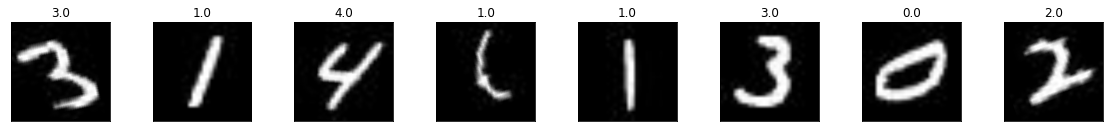

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [ ]:
img_transform = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((200, 200)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5,))
    ])

testset = datasets.MNIST('/content/drive/MyDrive/MIDAS/Point2/MNIST', download=True, train=False, transform=img_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

val_iter = iter(test_loader)
images1, labels = val_iter.next()
print('images shape on batch size = {}'.format(images1.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([64, 1, 200, 200])
labels shape on batch size = torch.Size([64])


In [ ]:
print(df_train.shape)
print(df_valid.shape)

(45000, 2)
(15000, 2)


In [ ]:
df_train.to_csv('/content/drive/MyDrive/MIDAS/Point3/train.csv', index = None)
df_valid.to_csv("/content/drive/MyDrive/MIDAS/Point3/valid.csv", index = None)

#Model Creation

<font size=3px>
1. Conv(1, 32) -> ReLU -> Dropout -> Maxpool</br>
2. Conv(32, 64) -> ReLU -> Dropout -> Maxpool</br>
3. Conv(64, 128) -> ReLU -> Dropout -> Maxpool</br>
4. Conv(128, 256) -> ReLU -> Dropout -> Maxpool</br>
5. Conv(256, 512) -> ReLU -> Dropout -> Maxpool</br>
6. Transformer Encoder Layer</br>
7. Transformer Encoder Layer</br>
8. Transformer Encoder Layer</br>
9. Fully Connected Layer (512, 10)</br>
</font>

In [ ]:
class smallModel(nn.Module):
  def __init__(self):
    super(smallModel, self).__init__()
    
    self.zp1 = nn.ZeroPad2d(1)
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.mp1 = nn.MaxPool2d(kernel_size=2)
    self.dp = nn.Dropout(p=0.3)

    self.zp2 = nn.ZeroPad2d(1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.mp2 = nn.MaxPool2d(kernel_size=2)
    #self.dp = nn.Dropout(p=0.3)

    self.zp3 = nn.ZeroPad2d(1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.mp3 = nn.MaxPool2d(kernel_size=2)

    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.mp4 = nn.MaxPool2d(kernel_size=2)

    self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
    self.mp5 = nn.MaxPool2d(kernel_size=2)

    self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=3)

    self.relu = nn.ReLU()

    self.fc1 = nn.Linear(512 * 6 * 6, 9216)
    self.fc2 = nn.Linear(9216, 4096)
    self.fc3 = nn.Linear(4096, 1024)
    self.fc4 = nn.Linear(512 * 6 * 6, 10)

    self.row_emb = nn.Parameter(torch.rand(64, 512 // 2))
    self.col_emb = nn.Parameter(torch.rand(64, 512 // 2))

  def forward(self, x):
    x = self.dp(self.relu(self.conv1(x)))
    x = self.mp1(x)

    x = self.dp(self.relu(self.conv2(x)))
    x = self.mp2(x)

    x = self.dp(self.relu(self.conv3(x)))
    x = self.mp3(x)

    x = self.dp(self.relu(self.conv4(x)))
    x = self.mp4(x)

    x = self.dp(self.relu(self.conv5(x)))
    x = self.mp5(x)

    H = x.shape[-1]
    W = x.shape[-2]
    pos = torch.cat([self.col_emb[:W].unsqueeze(0).repeat(H, 1, 1), self.row_emb[:H].unsqueeze(1).repeat(1, W, 1),], dim=-1).flatten(0, 1).unsqueeze(1)

    x = x.flatten(2).permute(2, 0, 1)

    x = self.transformer_encoder(pos + x)

    x = x.permute(1, 2, 0)
    x = torch.reshape(x, ((x.shape)[0], 512 * 36))

    #x = self.relu(self.fc1(x))
    #x = self.relu(self.fc2(x))
    #x = self.relu(self.fc3(x))
    x = self.fc4(x)
  
    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smallModel().to(device)
print(model)

smallModel(
  (zp1): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dp): Dropout(p=0.3, inplace=False)
  (zp2): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (zp3): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

#Model Training

In [ ]:
#Returns number of elements that are equal in the out (output) and labels (target) tensor
def accuracy(out, labels):
    count = 0
    _,pred = torch.max(out, dim=1)
    for i in range(output.shape[0]):
      if pred[i] == labels[i][0]:
        count = count + 1
    return count

In [ ]:
#42 mins
chkpt_path = "/content/drive/MyDrive/MIDAS/Point3/trained_scratch.pt"

train_loss_list = []
valid_loss_list = []
train_accuracy = []
valid_accuracy = []

epochs = 10
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss()
min_valid_loss = np.Inf
check_epoch = 5
epoch_no_improve = 0
i = 0


for epoch in range(1, 31):
  train_loss = 0
  valid_loss = 0
  tcorrect = 0
  vcorrect = 0
  model.train()

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Training: ")
  for batch, (img, target) in enumerate(train_loader):
    #print(batch)
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    optimizer.zero_grad()
    output = model(img)

    loss = criterion(output, target.view(-1))

    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    tcorrect += accuracy(output, target)
    _,pred = torch.max(output, dim=1)
   
  
    
  model.eval()
  print("Validation: ")
  for batch, (img, target) in enumerate(val_loader):
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    output = model(img)
    
    loss = criterion(output, target.view(-1))

    valid_loss += loss.item()
    vcorrect += accuracy(output, target)
    _,pred = torch.max(output, dim=1)
   
    
  # calculate average losses
  train_loss = train_loss/len(train_loader)
  valid_loss = valid_loss/len(val_loader)
  train_loss_list.append(train_loss)
  valid_loss_list.append(valid_loss)

  tcorrect = tcorrect/len(train_dataset)
  vcorrect = vcorrect/len(valid_dataset)
  train_accuracy.append(tcorrect)
  valid_accuracy.append(vcorrect)
  
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
      epoch, train_loss, tcorrect, valid_loss, vcorrect))
  

  if epoch % 5 == 0 :
    torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              }, chkpt_path)


Training: 
Validation: 
Epoch: 1 	Training Loss: 0.201383 	Training Accuracy: 0.938022 	Validation Loss: 0.083387 	Validation Accuracy: 0.975000
Training: 
Validation: 
Epoch: 2 	Training Loss: 0.086062 	Training Accuracy: 0.973778 	Validation Loss: 0.094396 	Validation Accuracy: 0.970333
Training: 
Validation: 
Epoch: 3 	Training Loss: 0.068563 	Training Accuracy: 0.979600 	Validation Loss: 0.056920 	Validation Accuracy: 0.982467
Training: 
Validation: 
Epoch: 4 	Training Loss: 0.056378 	Training Accuracy: 0.982533 	Validation Loss: 0.046196 	Validation Accuracy: 0.984867
Training: 
Validation: 
Epoch: 5 	Training Loss: 0.048349 	Training Accuracy: 0.984622 	Validation Loss: 0.030463 	Validation Accuracy: 0.990733
Training: 
Validation: 
Epoch: 6 	Training Loss: 0.043941 	Training Accuracy: 0.986067 	Validation Loss: 0.041932 	Validation Accuracy: 0.987867
Training: 
Validation: 
Epoch: 7 	Training Loss: 0.038401 	Training Accuracy: 0.987933 	Validation Loss: 0.031450 	Validation Accu

KeyboardInterrupt: ignored

#Visualisations and Evaluation

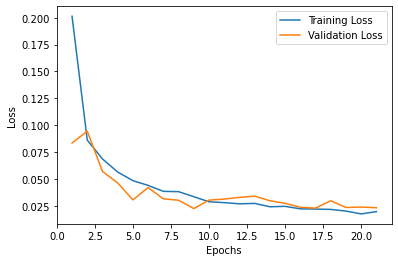

In [ ]:
#Without Augmentation
a = [i for  i in range(1, 22)]
plt.plot(a, train_loss_list, label = 'Training Loss')
plt.plot(a, valid_loss_list, label = 'Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

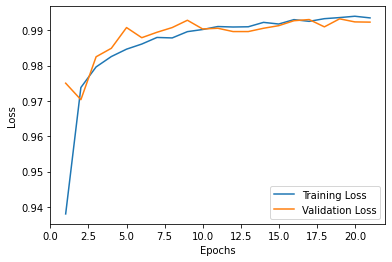

In [ ]:
#Without Augmentation
a = [i for  i in range(1, 22)]
plt.plot(a, train_accuracy, label = 'Training Loss')
plt.plot(a, valid_accuracy, label = 'Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
#Evaluation begins
i = 0
l1 = []
l2 = []

model.eval()
#test_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)
for batch, (img, target) in enumerate(val_loader):
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    output = model(img)
    
    #vcorrect += accuracy(output, target)
    _,pred = torch.max(output, dim=1)
    l1.append(pred.item())
    l2.append(target.item())

df = pd.DataFrame(columns=["Pred", "Target"])
df["Pred"] = l1
df["Target"] = l2
df.head()

,Pred,Target
0,9,9
1,9,9
2,1,1
3,1,1
4,9,9


In [ ]:
y = np.array(df["Target"])
y_pred = np.array(df["Pred"])

In [ ]:
print("Classification Report:")
print(classification_report(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1451
           1       0.98      1.00      0.99      1688
           2       0.99      0.99      0.99      1488
           3       1.00      0.99      1.00      1532
           4       0.99      0.99      0.99      1472
           5       0.99      1.00      0.99      1329
           6       0.99      0.99      0.99      1506
           7       0.99      0.99      0.99      1595
           8       1.00      0.98      0.99      1485
           9       0.99      0.98      0.99      1454

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000



#Evaluation on test set of MNIST

In [ ]:
def accuracy_test(out, labels):
    count = 0
    _,pred = torch.max(out, dim=1)
    for i in range(output.shape[0]):
      if pred[i] == labels[i]:
        count = count + 1
    return count

In [ ]:
#Evaluation begins
i = 0
l1 = []
l2 = []
vcorrect = 0

model.eval()
#test_loader = DataLoader(valset, batch_size=1, shuffle=True)
for batch, (img, target) in enumerate(test_loader):
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    output = model(img)
    
    vcorrect += accuracy_test(output, target)
    _,pred = torch.max(output, dim=1)
    l1.append(pred.tolist())
    l2.append(target.tolist())

vcorrect = vcorrect/(len(val_loader) * 64)
df = pd.DataFrame(columns=["Pred", "Target"])
l1 = [j for sub in l1 for j in sub]
l2 = [j for sub in l2 for j in sub]
df["Pred"] = l1
df["Target"] = l2
df.head()

,Pred,Target
0,6,6
1,5,5
2,1,1
3,4,4
4,7,7


In [ ]:
y = np.array(df["Target"])
y_pred = np.array(df["Pred"])

**Evaluation**<br>
At epoch 20:</br>
Training Accuracy: 99.39% 	
Validation Accuracy: 99.23%<br>
Test Accuracy: 99%

In [ ]:
print("Classification Report:")
print(classification_report(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.98      1.00      0.99      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       1.00      0.98      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

